# Netflix Data Analysis Project
**Dataset:** Netflix Movies and TV Shows (8,790 titles)

---

## Project Overview

In this project, I'm exploring Netflix's content library to understand their content strategy. The dataset contains information about movies and TV shows available on Netflix up to 2021.

**Questions I want to answer:**
- What's the split between movies and TV shows?
- Which countries produce the most content?
- How has Netflix's library grown over time?
- What are the most common genres and ratings?
- When does Netflix prefer to release new content?


## Setup and Imports

In [1]:
# importing the libraries i'll need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import warnings

warnings.filterwarnings('ignore')

# setting up the plot style - i like this clean look
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# netflix brand colors - makes the visualizations look cohesive
NETFLIX_RED = '#E50914'
NETFLIX_BLACK = '#141414'
NETFLIX_GRAY = '#564d4d'

# create folders for outputs
os.makedirs('visualizations', exist_ok=True)
os.makedirs('data', exist_ok=True)

print('Setup complete! Ready to analyze.')

Setup complete! Ready to analyze.


## Loading the Data

First, let me load the dataset and see what we're working with.

In [2]:
# load the data
df = pd.read_csv('/content/netflix1.csv')

print(f'Dataset loaded: {len(df)} records')
print(f'Columns: {len(df.columns)}')
df.head()

Dataset loaded: 8790 records
Columns: 10


,show_id,type,title,director,country,date_added,release_year,rating,duration,listed_in
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,United States,9/25/2021,2020,PG-13,90 min,Documentaries
1,s3,TV Show,Ganglands,Julien Leclercq,France,9/24/2021,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act..."
2,s6,TV Show,Midnight Mass,Mike Flanagan,United States,9/24/2021,2021,TV-MA,1 Season,"TV Dramas, TV Horror, TV Mysteries"
3,s14,Movie,Confessions of an Invisible Girl,Bruno Garotti,Brazil,9/22/2021,2021,TV-PG,91 min,"Children & Family Movies, Comedies"
4,s8,Movie,Sankofa,Haile Gerima,United States,9/24/2021,1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies"


In [3]:
# quick look at the data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8790 entries, 0 to 8789
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8790 non-null   object
 1   type          8790 non-null   object
 2   title         8790 non-null   object
 3   director      8790 non-null   object
 4   country       8790 non-null   object
 5   date_added    8790 non-null   object
 6   release_year  8790 non-null   int64 
 7   rating        8790 non-null   object
 8   duration      8790 non-null   object
 9   listed_in     8790 non-null   object
dtypes: int64(1), object(9)
memory usage: 686.8+ KB


In [4]:
# checking for nulls
print('Missing values per column:')
print(df.isnull().sum())
print()

# also checking for 'Not Given' placeholder values
print("'Not Given' placeholders:")
for col in df.columns:
    not_given = (df[col] == 'Not Given').sum()
    if not_given > 0:
        print(f'  {col}: {not_given}')

Missing values per column:
show_id         0
type            0
title           0
director        0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
dtype: int64

'Not Given' placeholders:
  director: 2588
  country: 287


## Data Cleaning

The data looks pretty clean already, but I need to:
1. Convert date_added to datetime
2. Extract some useful features from dates
3. Parse the duration column

In [5]:
# removing duplicates if any
initial_count = len(df)
df = df.drop_duplicates()
print(f'Removed {initial_count - len(df)} duplicates')

# convert date_added to datetime
df['date_added'] = pd.to_datetime(df['date_added'])

# extract year, month, day for analysis
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month
df['day_of_week'] = df['date_added'].dt.day_name()

# parse duration - movies have minutes, tv shows have seasons
df['duration_num'] = df['duration'].str.extract(r'(\d+)').astype(float)
df['duration_type'] = df['duration'].apply(lambda x: 'min' if 'min' in str(x) else 'season')

print('Date conversion done!')
print(f"Date range: {df['date_added'].min().strftime('%Y-%m-%d')} to {df['date_added'].max().strftime('%Y-%m-%d')}")

Removed 0 duplicates
Date conversion done!
Date range: 2008-01-01 to 2021-09-25


In [6]:
# let's see the cleaned data
df.head()

,show_id,type,title,director,country,date_added,release_year,rating,duration,listed_in,year_added,month_added,day_of_week,duration_num,duration_type
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,United States,2021-09-25,2020,PG-13,90 min,Documentaries,2021,9,Saturday,90.0,min
1,s3,TV Show,Ganglands,Julien Leclercq,France,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",2021,9,Friday,1.0,season
2,s6,TV Show,Midnight Mass,Mike Flanagan,United States,2021-09-24,2021,TV-MA,1 Season,"TV Dramas, TV Horror, TV Mysteries",2021,9,Friday,1.0,season
3,s14,Movie,Confessions of an Invisible Girl,Bruno Garotti,Brazil,2021-09-22,2021,TV-PG,91 min,"Children & Family Movies, Comedies",2021,9,Wednesday,91.0,min
4,s8,Movie,Sankofa,Haile Gerima,United States,2021-09-24,1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies",2021,9,Friday,125.0,min


In [7]:
# save cleaned data
df.to_csv('data/netflix_cleaned.csv', index=False)
print('Cleaned data saved to data/netflix_cleaned.csv')

Cleaned data saved to data/netflix_cleaned.csv


## Exploratory Data Analysis

Now for the fun part - let's explore the data and create some visualizations!

### 1. Movies vs TV Shows

What's the content split on Netflix?

In [8]:
# count movies and tv shows
type_counts = df['type'].value_counts()
print('Content breakdown:')
print(type_counts)
print()
print(f'Movies: {type_counts["Movie"]/len(df)*100:.1f}%')
print(f'TV Shows: {type_counts["TV Show"]/len(df)*100:.1f}%')

Content breakdown:
type
Movie      6126
TV Show    2664
Name: count, dtype: int64

Movies: 69.7%
TV Shows: 30.3%


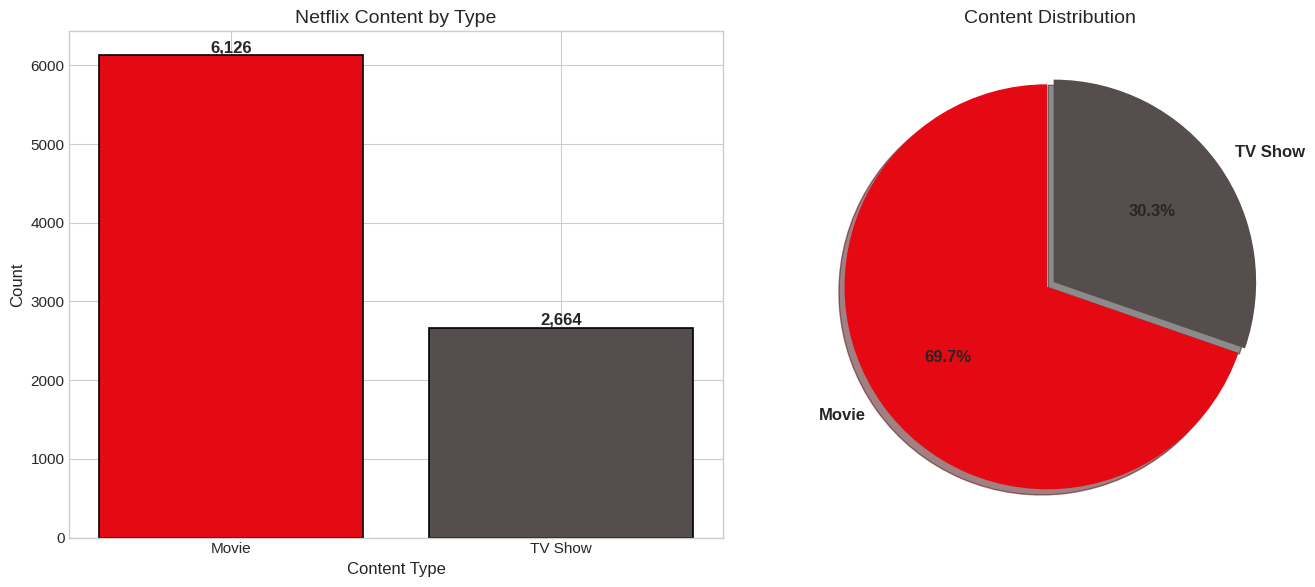

Saved: visualizations/01_content_type.png


In [9]:
# visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# bar chart
colors = [NETFLIX_RED, NETFLIX_GRAY]
bars = axes[0].bar(type_counts.index, type_counts.values, color=colors, edgecolor='black', linewidth=1.2)
axes[0].set_xlabel('Content Type')
axes[0].set_ylabel('Count')
axes[0].set_title('Netflix Content by Type')

# add labels on bars
for bar in bars:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height, f'{int(height):,}',
                 ha='center', va='bottom', fontweight='bold', fontsize=12)

# pie chart
axes[1].pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%',
            colors=colors, explode=(0.02, 0.02), shadow=True, startangle=90,
            textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[1].set_title('Content Distribution')

plt.tight_layout()
plt.savefig('visualizations/01_content_type.png', dpi=300, bbox_inches='tight')
plt.show()
print('Saved: visualizations/01_content_type.png')

Interesting! Movies make up about 70% of the catalog. Netflix clearly has more movies than TV shows.

### 2. Content Ratings Distribution

What age groups is Netflix targeting?

In [10]:
# ratings breakdown
rating_counts = df['rating'].value_counts()
print('Top 10 Ratings:')
print(rating_counts.head(10))

Top 10 Ratings:
rating
TV-MA    3205
TV-14    2157
TV-PG     861
R         799
PG-13     490
TV-Y7     333
TV-Y      306
PG        287
TV-G      220
NR         79
Name: count, dtype: int64


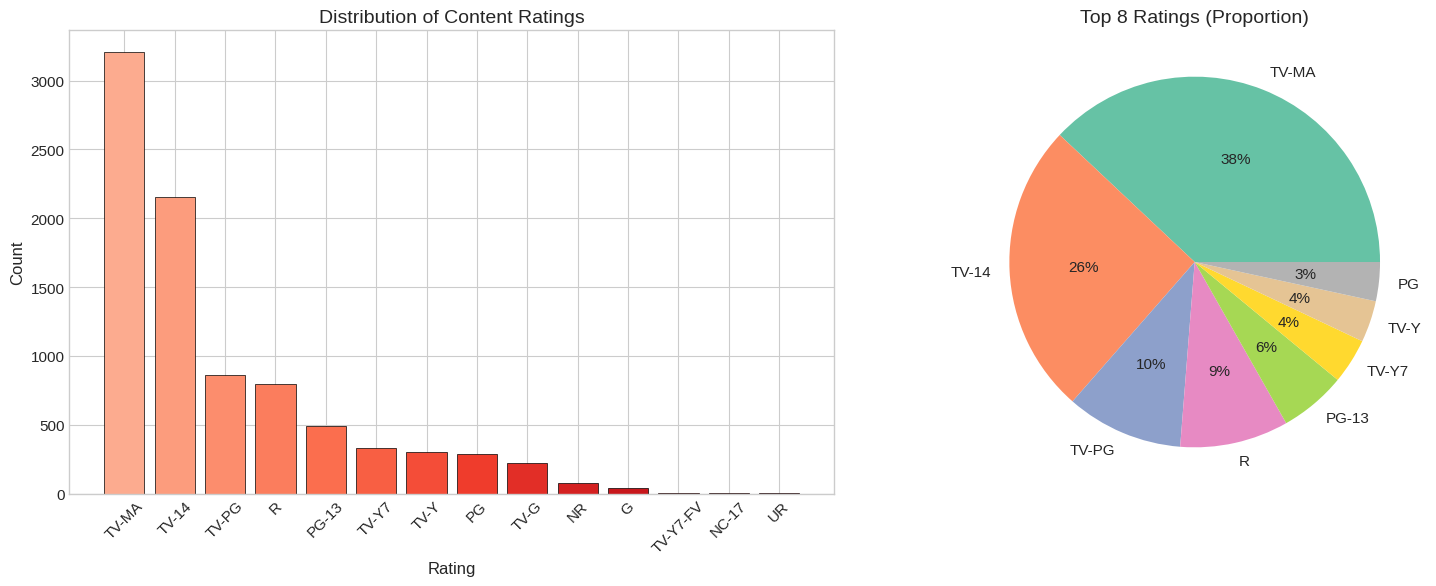

Saved: visualizations/02_ratings.png


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# bar chart - all ratings
colors_gradient = plt.cm.Reds(np.linspace(0.3, 0.9, len(rating_counts)))
axes[0].bar(rating_counts.index, rating_counts.values, color=colors_gradient, edgecolor='black', linewidth=0.5)
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Content Ratings')
axes[0].tick_params(axis='x', rotation=45)

# pie chart - top 8
top_ratings = rating_counts.head(8)
colors_pie = plt.cm.Set2(np.linspace(0, 1, 8))
axes[1].pie(top_ratings.values, labels=top_ratings.index, autopct='%1.0f%%', colors=colors_pie)
axes[1].set_title('Top 8 Ratings (Proportion)')

plt.tight_layout()
plt.savefig('visualizations/02_ratings.png', dpi=300, bbox_inches='tight')
plt.show()
print('Saved: visualizations/02_ratings.png')

TV-MA (mature audiences) is the most common rating by far. Netflix seems to focus heavily on adult content.

### 3. Top Countries

Where does Netflix's content come from?

In [12]:
# top 10 countries
country_counts = df['country'].value_counts().head(10)
print('Top 10 Content Producing Countries:')
print(country_counts)

Top 10 Content Producing Countries:
country
United States     3240
India             1057
United Kingdom     638
Pakistan           421
Not Given          287
Canada             271
Japan              259
South Korea        214
France             213
Spain              182
Name: count, dtype: int64


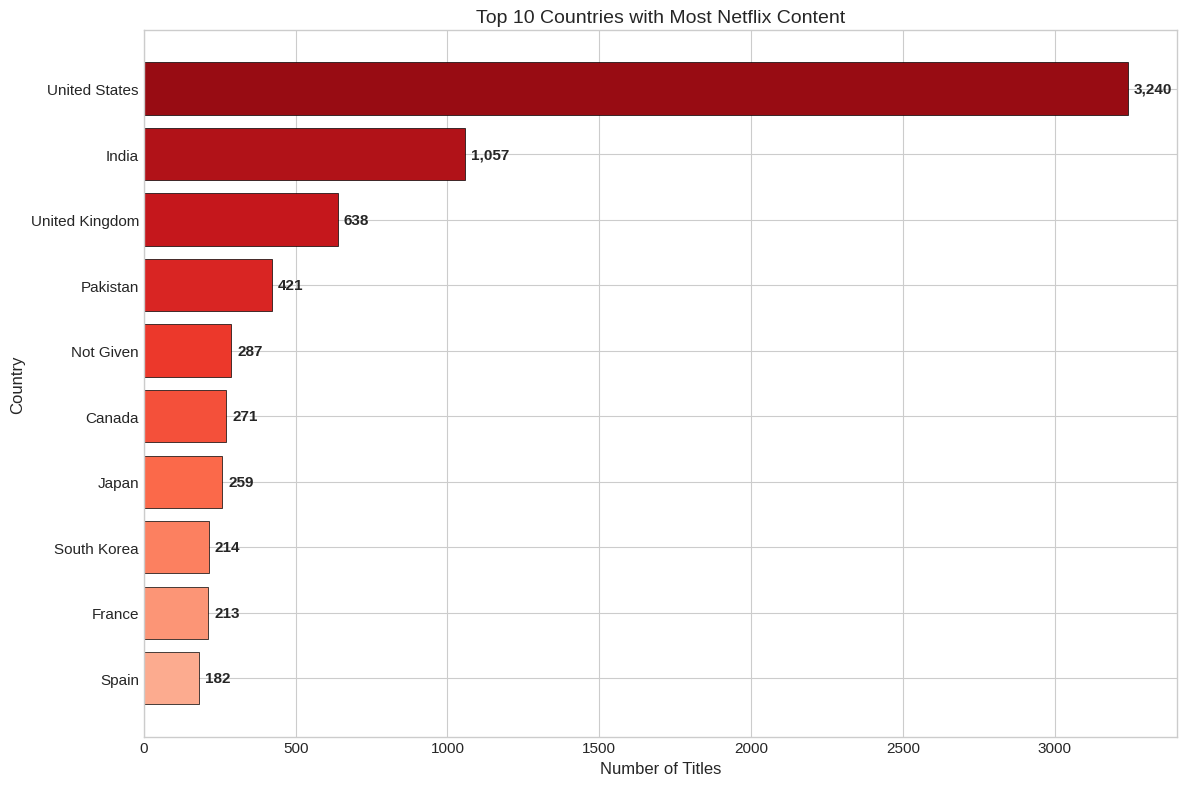

Saved: visualizations/03_top_countries.png


In [13]:
fig, ax = plt.subplots(figsize=(12, 8))

colors = plt.cm.Reds(np.linspace(0.3, 0.9, len(country_counts)))[::-1]
bars = ax.barh(country_counts.index, country_counts.values, color=colors, edgecolor='black', linewidth=0.5)
ax.set_xlabel('Number of Titles')
ax.set_ylabel('Country')
ax.set_title('Top 10 Countries with Most Netflix Content')
ax.invert_yaxis()

# add value labels
for bar in bars:
    width = bar.get_width()
    ax.text(width + 20, bar.get_y() + bar.get_height()/2, f'{int(width):,}',
            ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('visualizations/03_top_countries.png', dpi=300, bbox_inches='tight')
plt.show()
print('Saved: visualizations/03_top_countries.png')

US dominates with over 3,200 titles. India comes second - makes sense given their huge film industry.

### 4. Content Growth Over Time

How has Netflix's library grown year by year?

In [14]:
# yearly content additions
yearly_movies = df[df['type'] == 'Movie']['year_added'].value_counts().sort_index()
yearly_shows = df[df['type'] == 'TV Show']['year_added'].value_counts().sort_index()

print('Yearly additions (total):')
print(df['year_added'].value_counts().sort_index())

Yearly additions (total):
year_added
2008       2
2009       2
2010       1
2011      13
2012       3
2013      11
2014      24
2015      82
2016     426
2017    1185
2018    1648
2019    2016
2020    1879
2021    1498
Name: count, dtype: int64


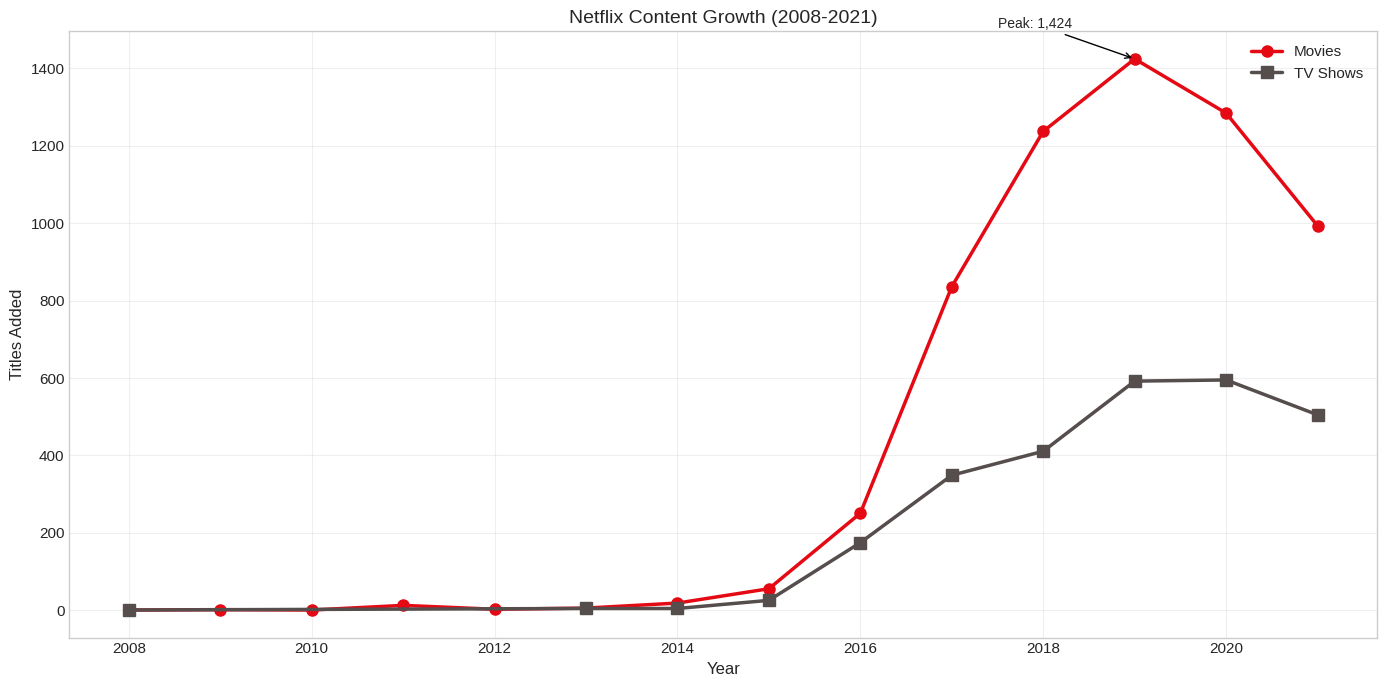

Saved: visualizations/04_yearly_growth.png


In [15]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(yearly_movies.index, yearly_movies.values, marker='o', linewidth=2.5,
        markersize=8, color=NETFLIX_RED, label='Movies')
ax.plot(yearly_shows.index, yearly_shows.values, marker='s', linewidth=2.5,
        markersize=8, color=NETFLIX_GRAY, label='TV Shows')

ax.set_xlabel('Year')
ax.set_ylabel('Titles Added')
ax.set_title('Netflix Content Growth (2008-2021)')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# mark the peak
peak_year = yearly_movies.idxmax()
peak_val = yearly_movies.max()
ax.annotate(f'Peak: {int(peak_val):,}', xy=(peak_year, peak_val),
            xytext=(peak_year-1.5, peak_val+80), fontsize=10,
            arrowprops=dict(arrowstyle='->', color='black'))

plt.tight_layout()
plt.savefig('visualizations/04_yearly_growth.png', dpi=300, bbox_inches='tight')
plt.show()
print('Saved: visualizations/04_yearly_growth.png')

Massive growth starting around 2015-2016. Peak was in 2019, then it dropped a bit (maybe COVID affected production?).

### 5. Monthly Release Patterns

Is there a seasonal pattern to when Netflix adds content?

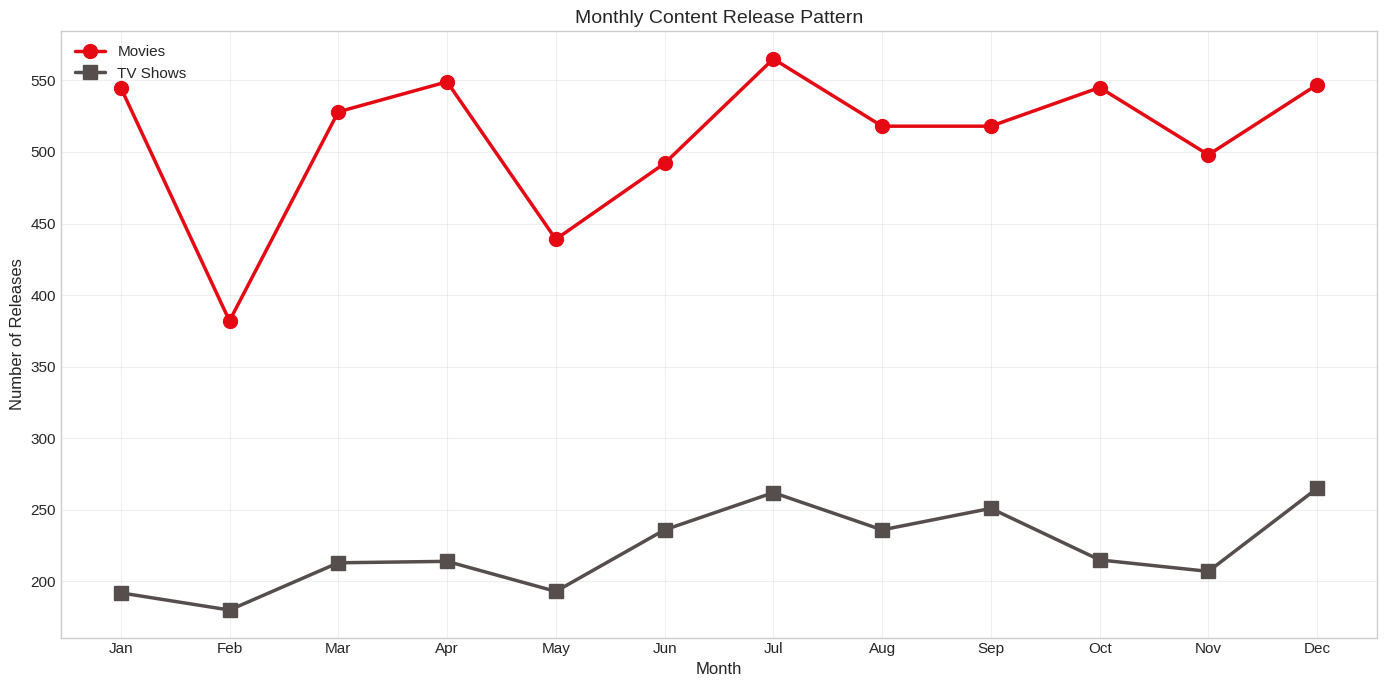

Saved: visualizations/05_monthly_pattern.png


In [16]:
monthly_movies = df[df['type'] == 'Movie']['month_added'].value_counts().sort_index()
monthly_shows = df[df['type'] == 'TV Show']['month_added'].value_counts().sort_index()

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(monthly_movies.index, monthly_movies.values, marker='o', linewidth=2.5,
        markersize=10, color=NETFLIX_RED, label='Movies')
ax.plot(monthly_shows.index, monthly_shows.values, marker='s', linewidth=2.5,
        markersize=10, color=NETFLIX_GRAY, label='TV Shows')

ax.set_xlabel('Month')
ax.set_ylabel('Number of Releases')
ax.set_title('Monthly Content Release Pattern')
ax.set_xticks(range(1, 13))
ax.set_xticklabels(months)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('visualizations/05_monthly_pattern.png', dpi=300, bbox_inches='tight')
plt.show()
print('Saved: visualizations/05_monthly_pattern.png')

### 6. Top Genres - Movies

In [17]:
# top movie genres
movie_genres = df[df['type'] == 'Movie'].groupby('listed_in').size().sort_values(ascending=False).head(10)
print('Top 10 Movie Genre Combinations:')
print(movie_genres)

Top 10 Movie Genre Combinations:
listed_in
Dramas, International Movies                        362
Documentaries                                       359
Stand-Up Comedy                                     334
Comedies, Dramas, International Movies              274
Dramas, Independent Movies, International Movies    252
Children & Family Movies                            215
Children & Family Movies, Comedies                  201
Documentaries, International Movies                 186
Dramas, International Movies, Romantic Movies       180
Comedies, International Movies                      176
dtype: int64


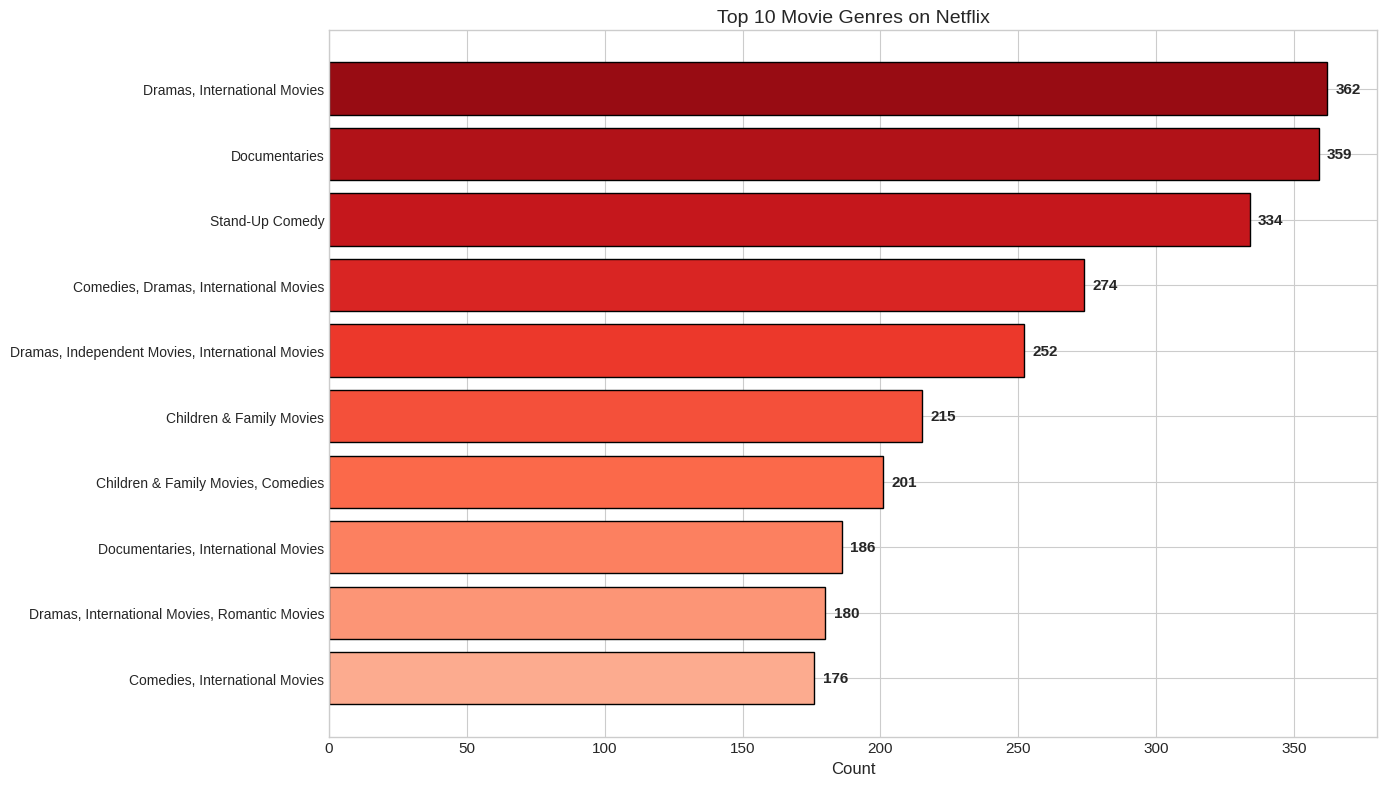

Saved: visualizations/06_movie_genres.png


In [18]:
fig, ax = plt.subplots(figsize=(14, 8))

colors = plt.cm.Reds(np.linspace(0.3, 0.9, len(movie_genres)))[::-1]
bars = ax.barh(range(len(movie_genres)), movie_genres.values, color=colors, edgecolor='black')
ax.set_yticks(range(len(movie_genres)))
ax.set_yticklabels(movie_genres.index, fontsize=10)
ax.set_xlabel('Count')
ax.set_title('Top 10 Movie Genres on Netflix')
ax.invert_yaxis()

for bar in bars:
    width = bar.get_width()
    ax.text(width + 3, bar.get_y() + bar.get_height()/2, f'{int(width)}',
            ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('visualizations/06_movie_genres.png', dpi=300, bbox_inches='tight')
plt.show()
print('Saved: visualizations/06_movie_genres.png')

### 7. Top Genres - TV Shows

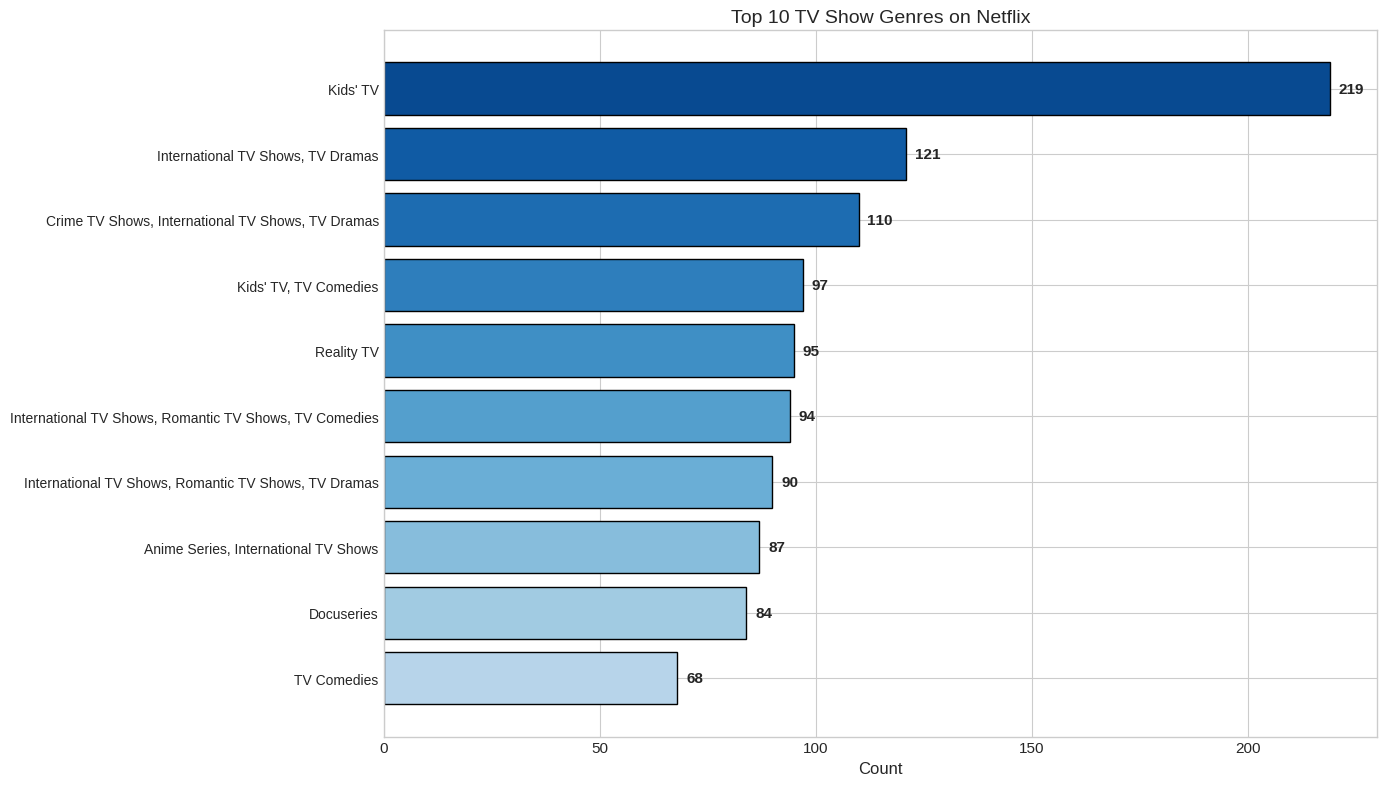

Saved: visualizations/07_tvshow_genres.png


In [19]:
# top tv show genres
show_genres = df[df['type'] == 'TV Show'].groupby('listed_in').size().sort_values(ascending=False).head(10)

fig, ax = plt.subplots(figsize=(14, 8))

colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(show_genres)))[::-1]
bars = ax.barh(range(len(show_genres)), show_genres.values, color=colors, edgecolor='black')
ax.set_yticks(range(len(show_genres)))
ax.set_yticklabels(show_genres.index, fontsize=10)
ax.set_xlabel('Count')
ax.set_title('Top 10 TV Show Genres on Netflix')
ax.invert_yaxis()

for bar in bars:
    width = bar.get_width()
    ax.text(width + 2, bar.get_y() + bar.get_height()/2, f'{int(width)}',
            ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('visualizations/07_tvshow_genres.png', dpi=300, bbox_inches='tight')
plt.show()
print('Saved: visualizations/07_tvshow_genres.png')

### 8. Top Directors

In [20]:
# top directors (excluding 'Not Given')
directors = df[df['director'] != 'Not Given']['director'].value_counts().head(15)
print('Top 15 Directors:')
print(directors)

Top 15 Directors:
director
Rajiv Chilaka                   20
Raúl Campos, Jan Suter          18
Alastair Fothergill             18
Suhas Kadav                     16
Marcus Raboy                    16
Jay Karas                       14
Cathy Garcia-Molina             13
Youssef Chahine                 12
Martin Scorsese                 12
Jay Chapman                     12
Steven Spielberg                11
Don Michael Paul                10
Mark Thornton, Todd Kauffman    10
David Dhawan                     9
Kunle Afolayan                   8
Name: count, dtype: int64


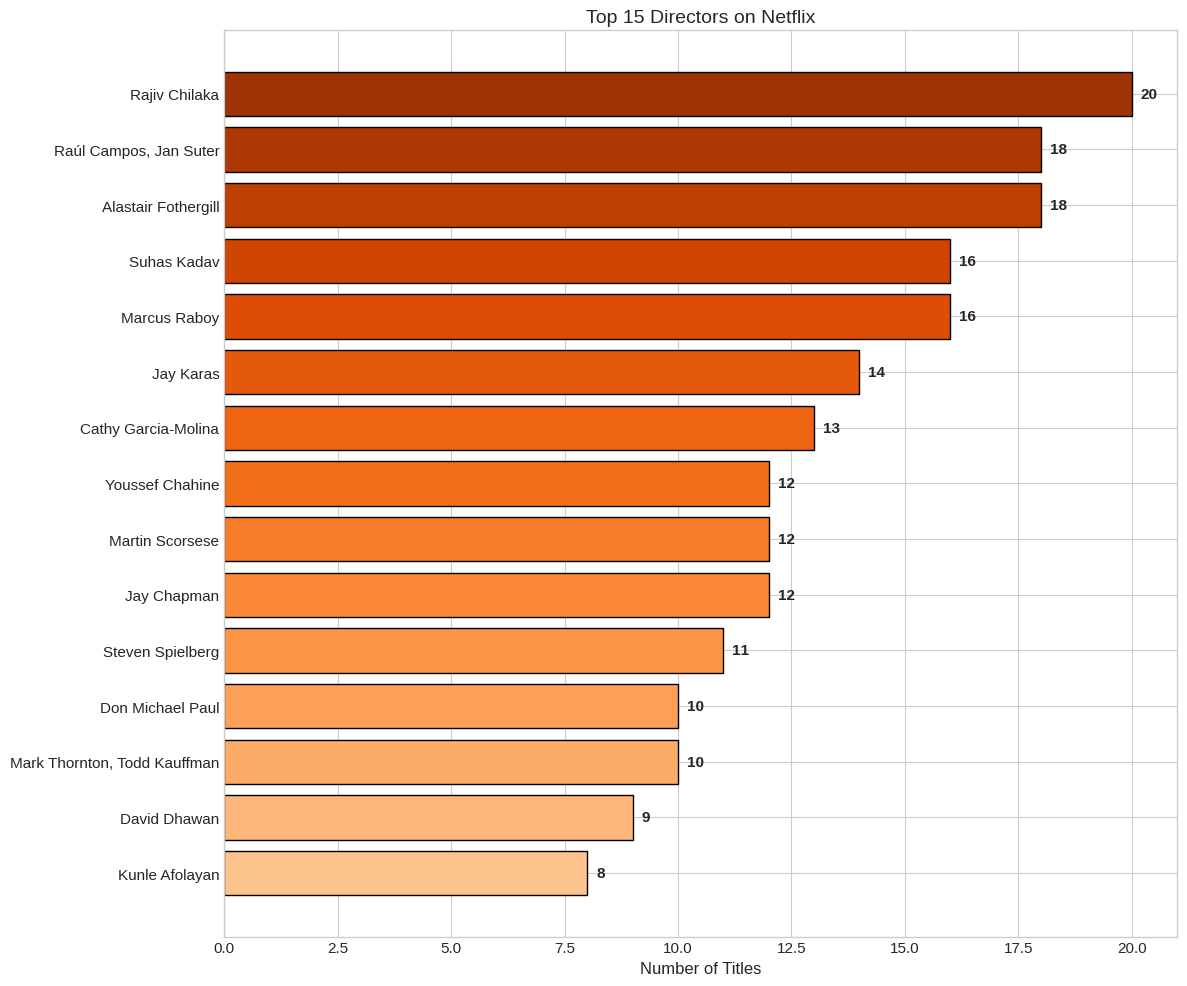

Saved: visualizations/08_top_directors.png


In [21]:
fig, ax = plt.subplots(figsize=(12, 10))

colors = plt.cm.Oranges(np.linspace(0.3, 0.9, len(directors)))[::-1]
bars = ax.barh(directors.index, directors.values, color=colors, edgecolor='black')
ax.set_xlabel('Number of Titles')
ax.set_title('Top 15 Directors on Netflix')
ax.invert_yaxis()

for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.2, bar.get_y() + bar.get_height()/2, f'{int(width)}',
            ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('visualizations/08_top_directors.png', dpi=300, bbox_inches='tight')
plt.show()
print('Saved: visualizations/08_top_directors.png')

### 9. Movie Duration Analysis

In [22]:
# movie durations
movie_duration = df[(df['type'] == 'Movie') & (df['duration_type'] == 'min')]['duration_num']

print('Movie Duration Stats:')
print(f'  Min: {movie_duration.min():.0f} min')
print(f'  Max: {movie_duration.max():.0f} min')
print(f'  Mean: {movie_duration.mean():.1f} min')
print(f'  Median: {movie_duration.median():.0f} min')

Movie Duration Stats:
  Min: 3 min
  Max: 312 min
  Mean: 99.6 min
  Median: 98 min


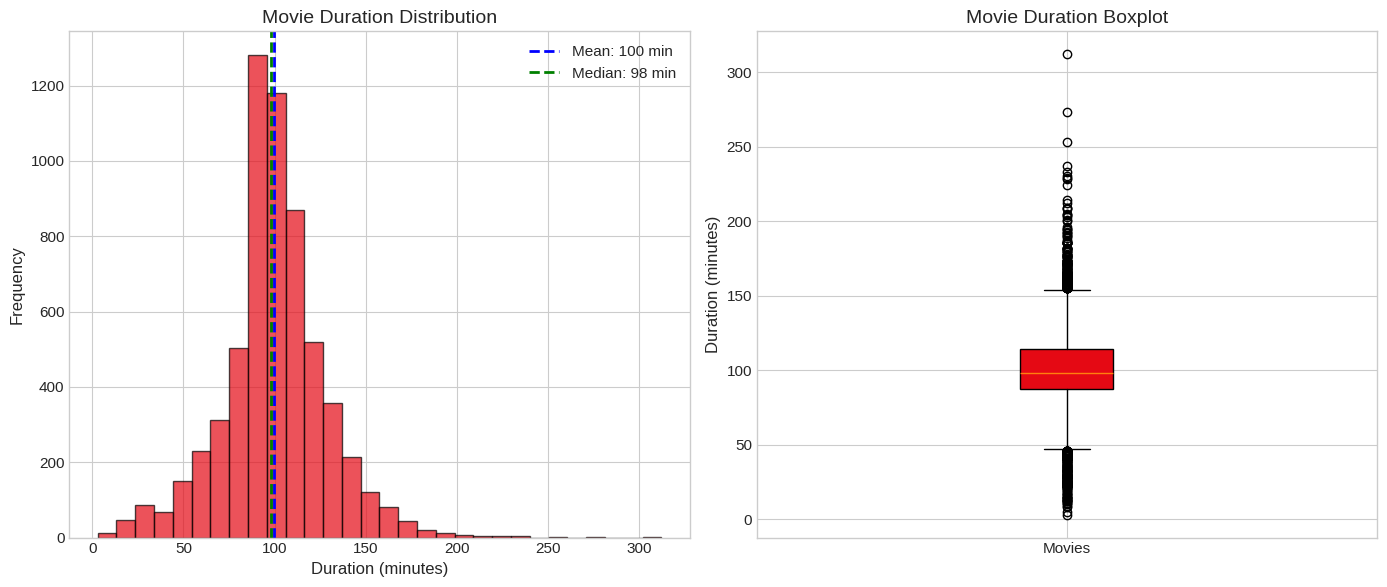

Saved: visualizations/09_movie_duration.png


In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# histogram
axes[0].hist(movie_duration, bins=30, color=NETFLIX_RED, edgecolor='black', alpha=0.7)
axes[0].axvline(movie_duration.mean(), color='blue', linestyle='--', linewidth=2,
                label=f'Mean: {movie_duration.mean():.0f} min')
axes[0].axvline(movie_duration.median(), color='green', linestyle='--', linewidth=2,
                label=f'Median: {movie_duration.median():.0f} min')
axes[0].set_xlabel('Duration (minutes)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Movie Duration Distribution')
axes[0].legend()

# boxplot
bp = axes[1].boxplot(movie_duration.dropna(), patch_artist=True, vert=True)
bp['boxes'][0].set_facecolor(NETFLIX_RED)
axes[1].set_ylabel('Duration (minutes)')
axes[1].set_title('Movie Duration Boxplot')
axes[1].set_xticklabels(['Movies'])

plt.tight_layout()
plt.savefig('visualizations/09_movie_duration.png', dpi=300, bbox_inches='tight')
plt.show()
print('Saved: visualizations/09_movie_duration.png')

Average movie is about 100 minutes. Pretty standard length.

### 10. TV Show Seasons

In [24]:
# tv show seasons
show_seasons = df[(df['type'] == 'TV Show') & (df['duration_type'] == 'season')]['duration_num']

print('TV Show Season Stats:')
print(f'  Min: {show_seasons.min():.0f} season(s)')
print(f'  Max: {show_seasons.max():.0f} seasons')
print(f'  Mean: {show_seasons.mean():.1f} seasons')
print(f'  Median: {show_seasons.median():.0f} season(s)')

print('\nSeason distribution:')
print(show_seasons.value_counts().sort_index().head(10))

TV Show Season Stats:
  Min: 1 season(s)
  Max: 17 seasons
  Mean: 1.8 seasons
  Median: 1 season(s)

Season distribution:
duration_num
1.0     1791
2.0      421
3.0      198
4.0       94
5.0       64
6.0       33
7.0       23
8.0       17
9.0        9
10.0       6
Name: count, dtype: int64


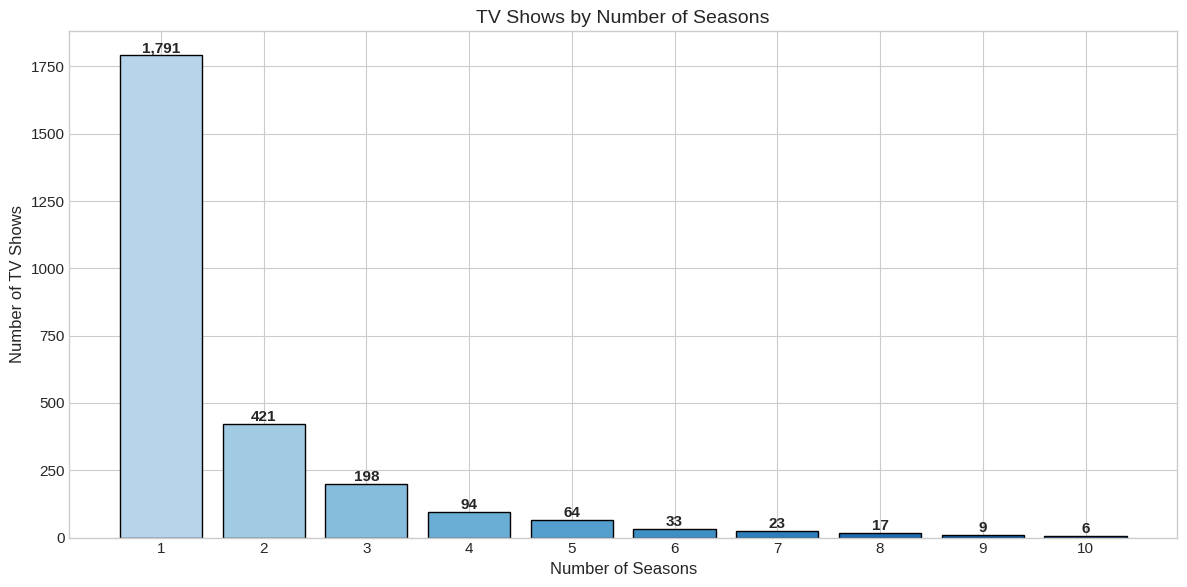

Saved: visualizations/10_tvshow_seasons.png


In [25]:
season_counts = show_seasons.value_counts().sort_index().head(10)

fig, ax = plt.subplots(figsize=(12, 6))

colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(season_counts)))
bars = ax.bar(season_counts.index.astype(int), season_counts.values, color=colors, edgecolor='black')
ax.set_xlabel('Number of Seasons')
ax.set_ylabel('Number of TV Shows')
ax.set_title('TV Shows by Number of Seasons')
ax.set_xticks(range(1, 11))

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height, f'{int(height):,}',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('visualizations/10_tvshow_seasons.png', dpi=300, bbox_inches='tight')
plt.show()
print('Saved: visualizations/10_tvshow_seasons.png')

Most TV shows only have 1 season. Could be limited series or shows that got cancelled.

### 11. Release Year Distribution

In [26]:
release_years = df['release_year'].value_counts().sort_index()
recent_years = release_years[release_years.index >= 2000]

print(f'Release year range: {df["release_year"].min()} - {df["release_year"].max()}')
print(f'Peak year: {release_years.idxmax()} ({release_years.max()} titles)')

Release year range: 1925 - 2021
Peak year: 2018 (1146 titles)


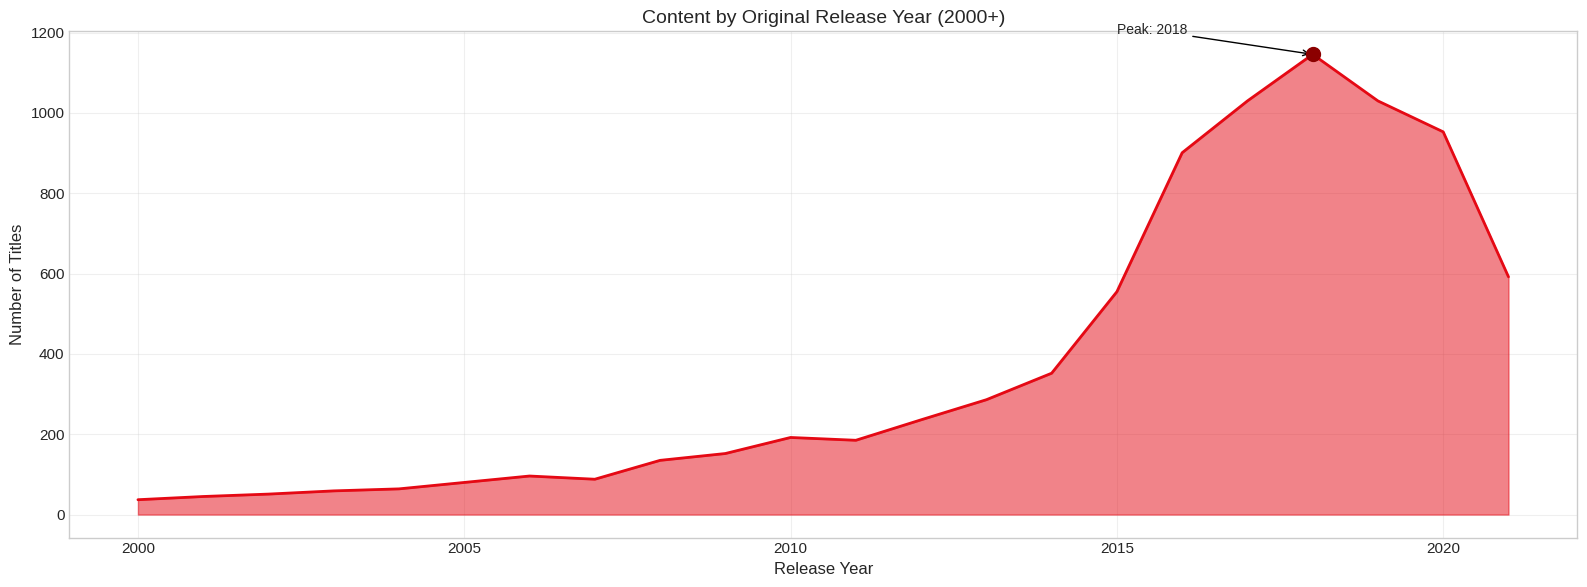

Saved: visualizations/11_release_year.png


In [27]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.fill_between(recent_years.index, recent_years.values, alpha=0.5, color=NETFLIX_RED)
ax.plot(recent_years.index, recent_years.values, color=NETFLIX_RED, linewidth=2)
ax.set_xlabel('Release Year')
ax.set_ylabel('Number of Titles')
ax.set_title('Content by Original Release Year (2000+)')
ax.grid(True, alpha=0.3)

# mark peak
peak = release_years.idxmax()
ax.scatter([peak], [release_years.max()], color='darkred', s=100, zorder=5)
ax.annotate(f'Peak: {peak}', xy=(peak, release_years.max()),
            xytext=(peak-3, release_years.max()+50), fontsize=10,
            arrowprops=dict(arrowstyle='->', color='black'))

plt.tight_layout()
plt.savefig('visualizations/11_release_year.png', dpi=300, bbox_inches='tight')
plt.show()
print('Saved: visualizations/11_release_year.png')

### 12. Common Words in Titles

In [28]:
# word frequency in movie titles
all_titles = ' '.join(df[df['type'] == 'Movie']['title'].tolist()).lower()
words = re.findall(r'\b[a-z]{4,}\b', all_titles)  # words with 4+ letters
word_freq = pd.Series(words).value_counts().head(20)

print('Most common words in movie titles:')
print(word_freq)

Most common words in movie titles:
love         106
movie         72
christmas     72
story         62
life          53
from          50
world         50
with          46
little        44
last          42
live          40
american      40
time          40
black         38
what          35
high          34
girl          34
house         32
monster       31
super         28
Name: count, dtype: int64


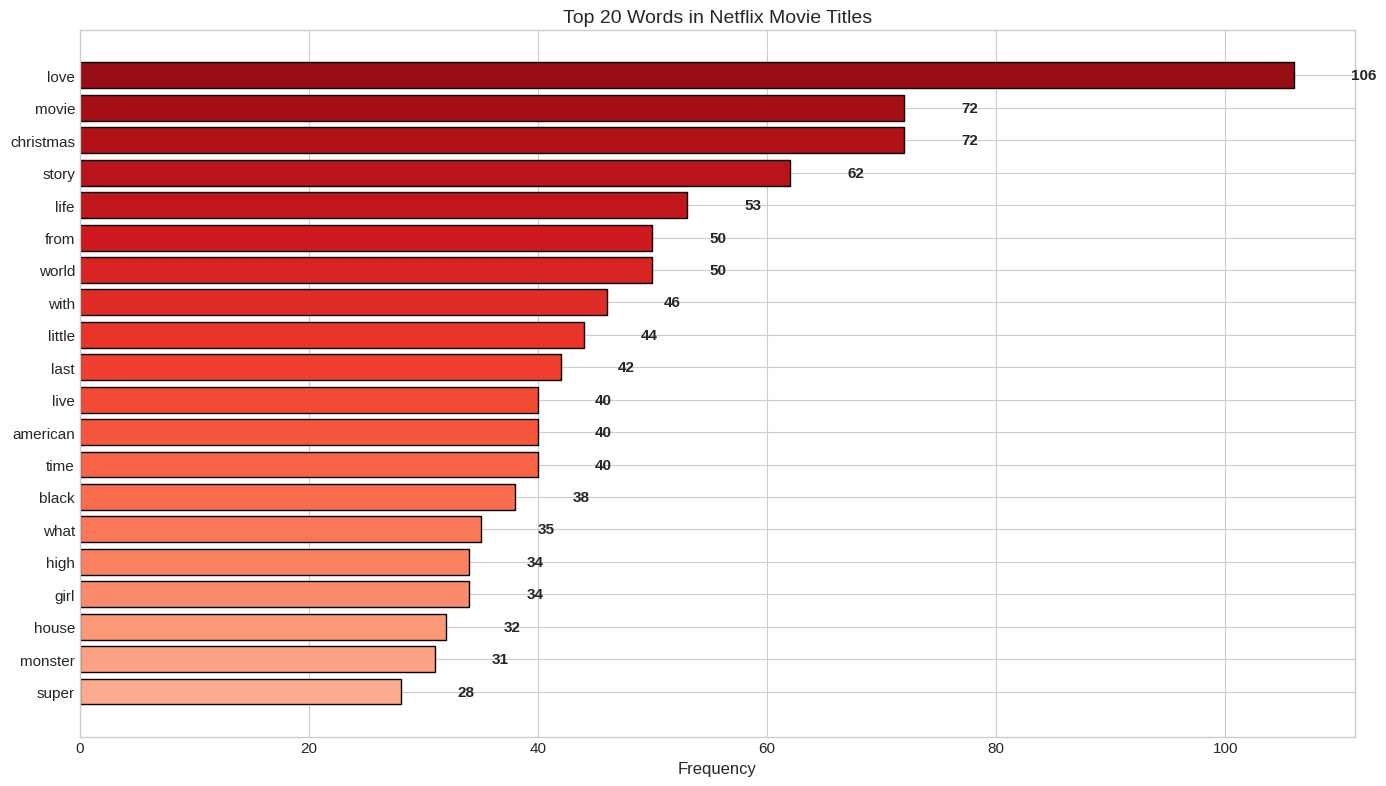

Saved: visualizations/12_title_words.png


In [29]:
fig, ax = plt.subplots(figsize=(14, 8))

colors = plt.cm.Reds(np.linspace(0.3, 0.9, len(word_freq)))[::-1]
bars = ax.barh(word_freq.index[::-1], word_freq.values[::-1], color=colors[::-1], edgecolor='black')
ax.set_xlabel('Frequency')
ax.set_title('Top 20 Words in Netflix Movie Titles')

for bar in bars:
    width = bar.get_width()
    ax.text(width + 5, bar.get_y() + bar.get_height()/2, f'{int(width)}',
            ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('visualizations/12_title_words.png', dpi=300, bbox_inches='tight')
plt.show()
print('Saved: visualizations/12_title_words.png')

### 13. Rating by Content Type (Heatmap)

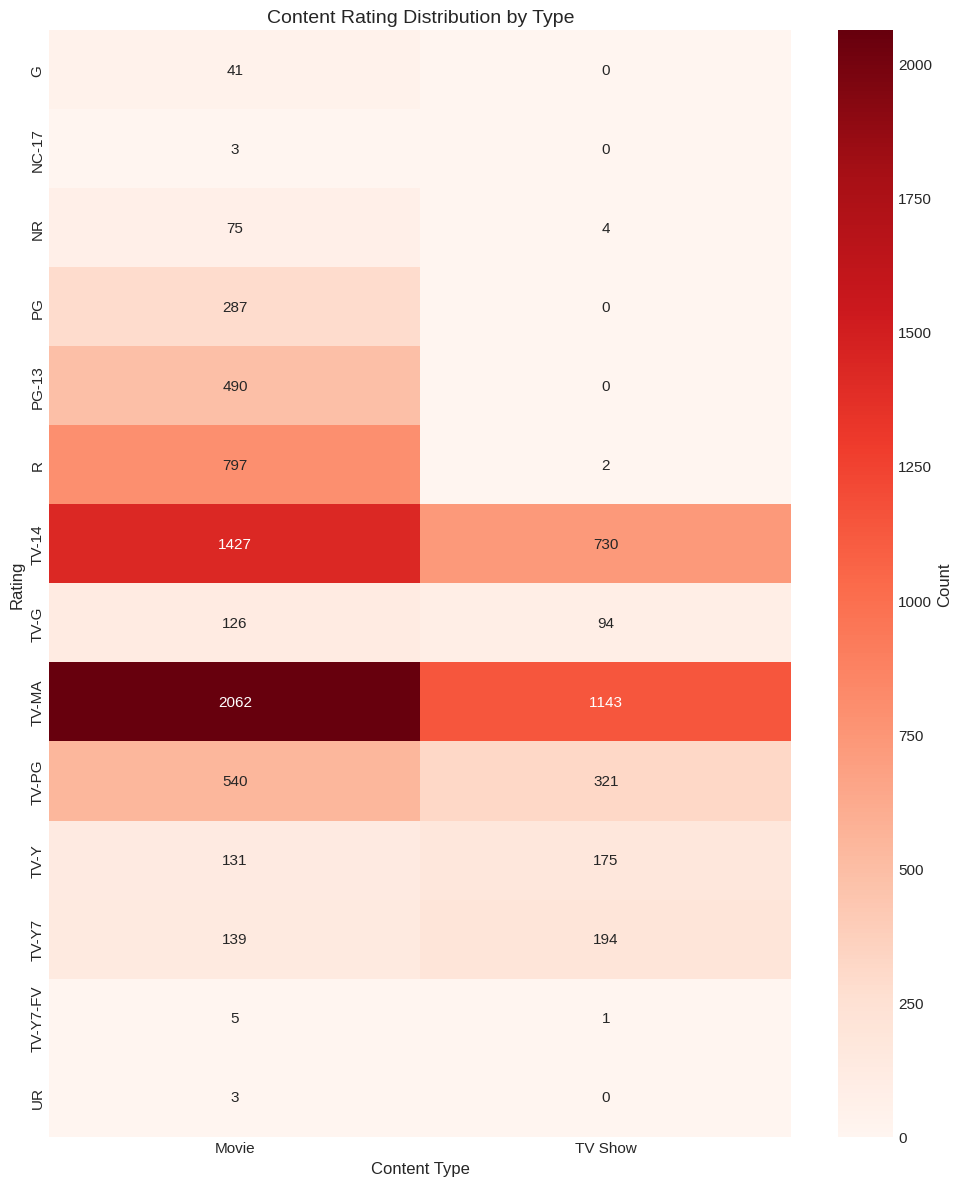

Saved: visualizations/13_rating_heatmap.png


In [30]:
# cross-tabulation
rating_type = pd.crosstab(df['rating'], df['type'])

fig, ax = plt.subplots(figsize=(10, 12))

sns.heatmap(rating_type, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'}, ax=ax)
ax.set_xlabel('Content Type')
ax.set_ylabel('Rating')
ax.set_title('Content Rating Distribution by Type')

plt.tight_layout()
plt.savefig('visualizations/13_rating_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
print('Saved: visualizations/13_rating_heatmap.png')

### 14. Day of Week Release Pattern

In [31]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = df['day_of_week'].value_counts().reindex(day_order)

print('Content added by day:')
print(day_counts)

Content added by day:
day_of_week
Monday        850
Tuesday      1196
Wednesday    1287
Thursday     1393
Friday       2497
Saturday      816
Sunday        751
Name: count, dtype: int64


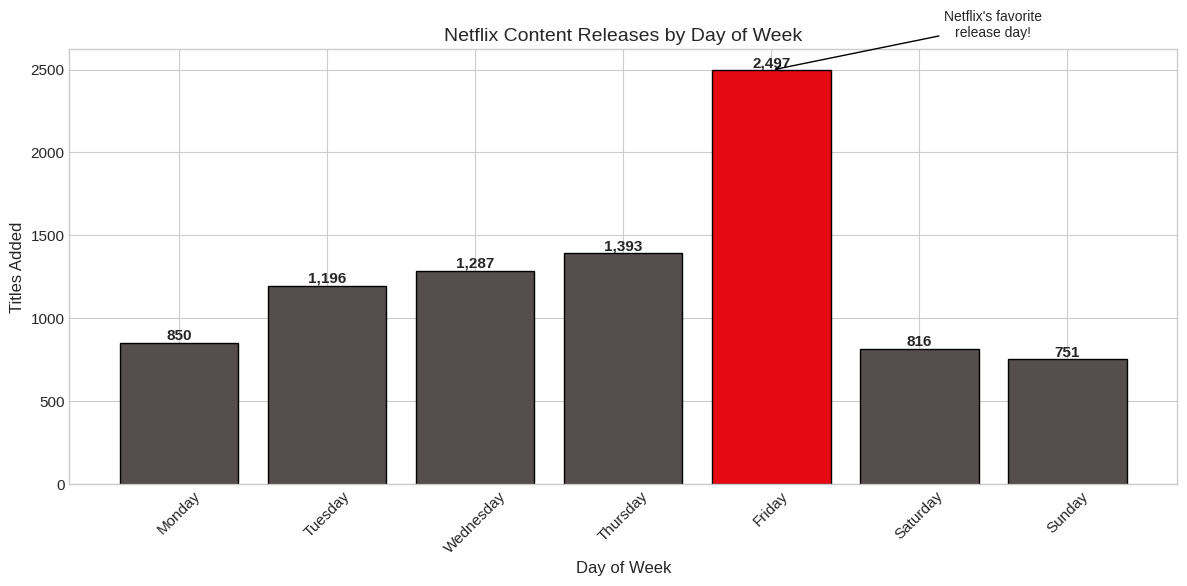

Saved: visualizations/14_day_of_week.png


In [32]:
fig, ax = plt.subplots(figsize=(12, 6))

colors = [NETFLIX_RED if day == 'Friday' else NETFLIX_GRAY for day in day_order]
bars = ax.bar(day_counts.index, day_counts.values, color=colors, edgecolor='black')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Titles Added')
ax.set_title('Netflix Content Releases by Day of Week')
ax.tick_params(axis='x', rotation=45)

for bar in bars:
    height = bar.get_height()
    if pd.notna(height):
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{int(height):,}',
                ha='center', va='bottom', fontweight='bold')

# highlight friday
ax.annotate('Netflix\'s favorite\nrelease day!', xy=(4, day_counts['Friday']),
            xytext=(5.5, day_counts['Friday']+200), fontsize=10, ha='center',
            arrowprops=dict(arrowstyle='->', color='black'))

plt.tight_layout()
plt.savefig('visualizations/14_day_of_week.png', dpi=300, bbox_inches='tight')
plt.show()
print('Saved: visualizations/14_day_of_week.png')

Friday is clearly the preferred release day - makes sense since people have the weekend to binge!

---

## Dashboard Summary

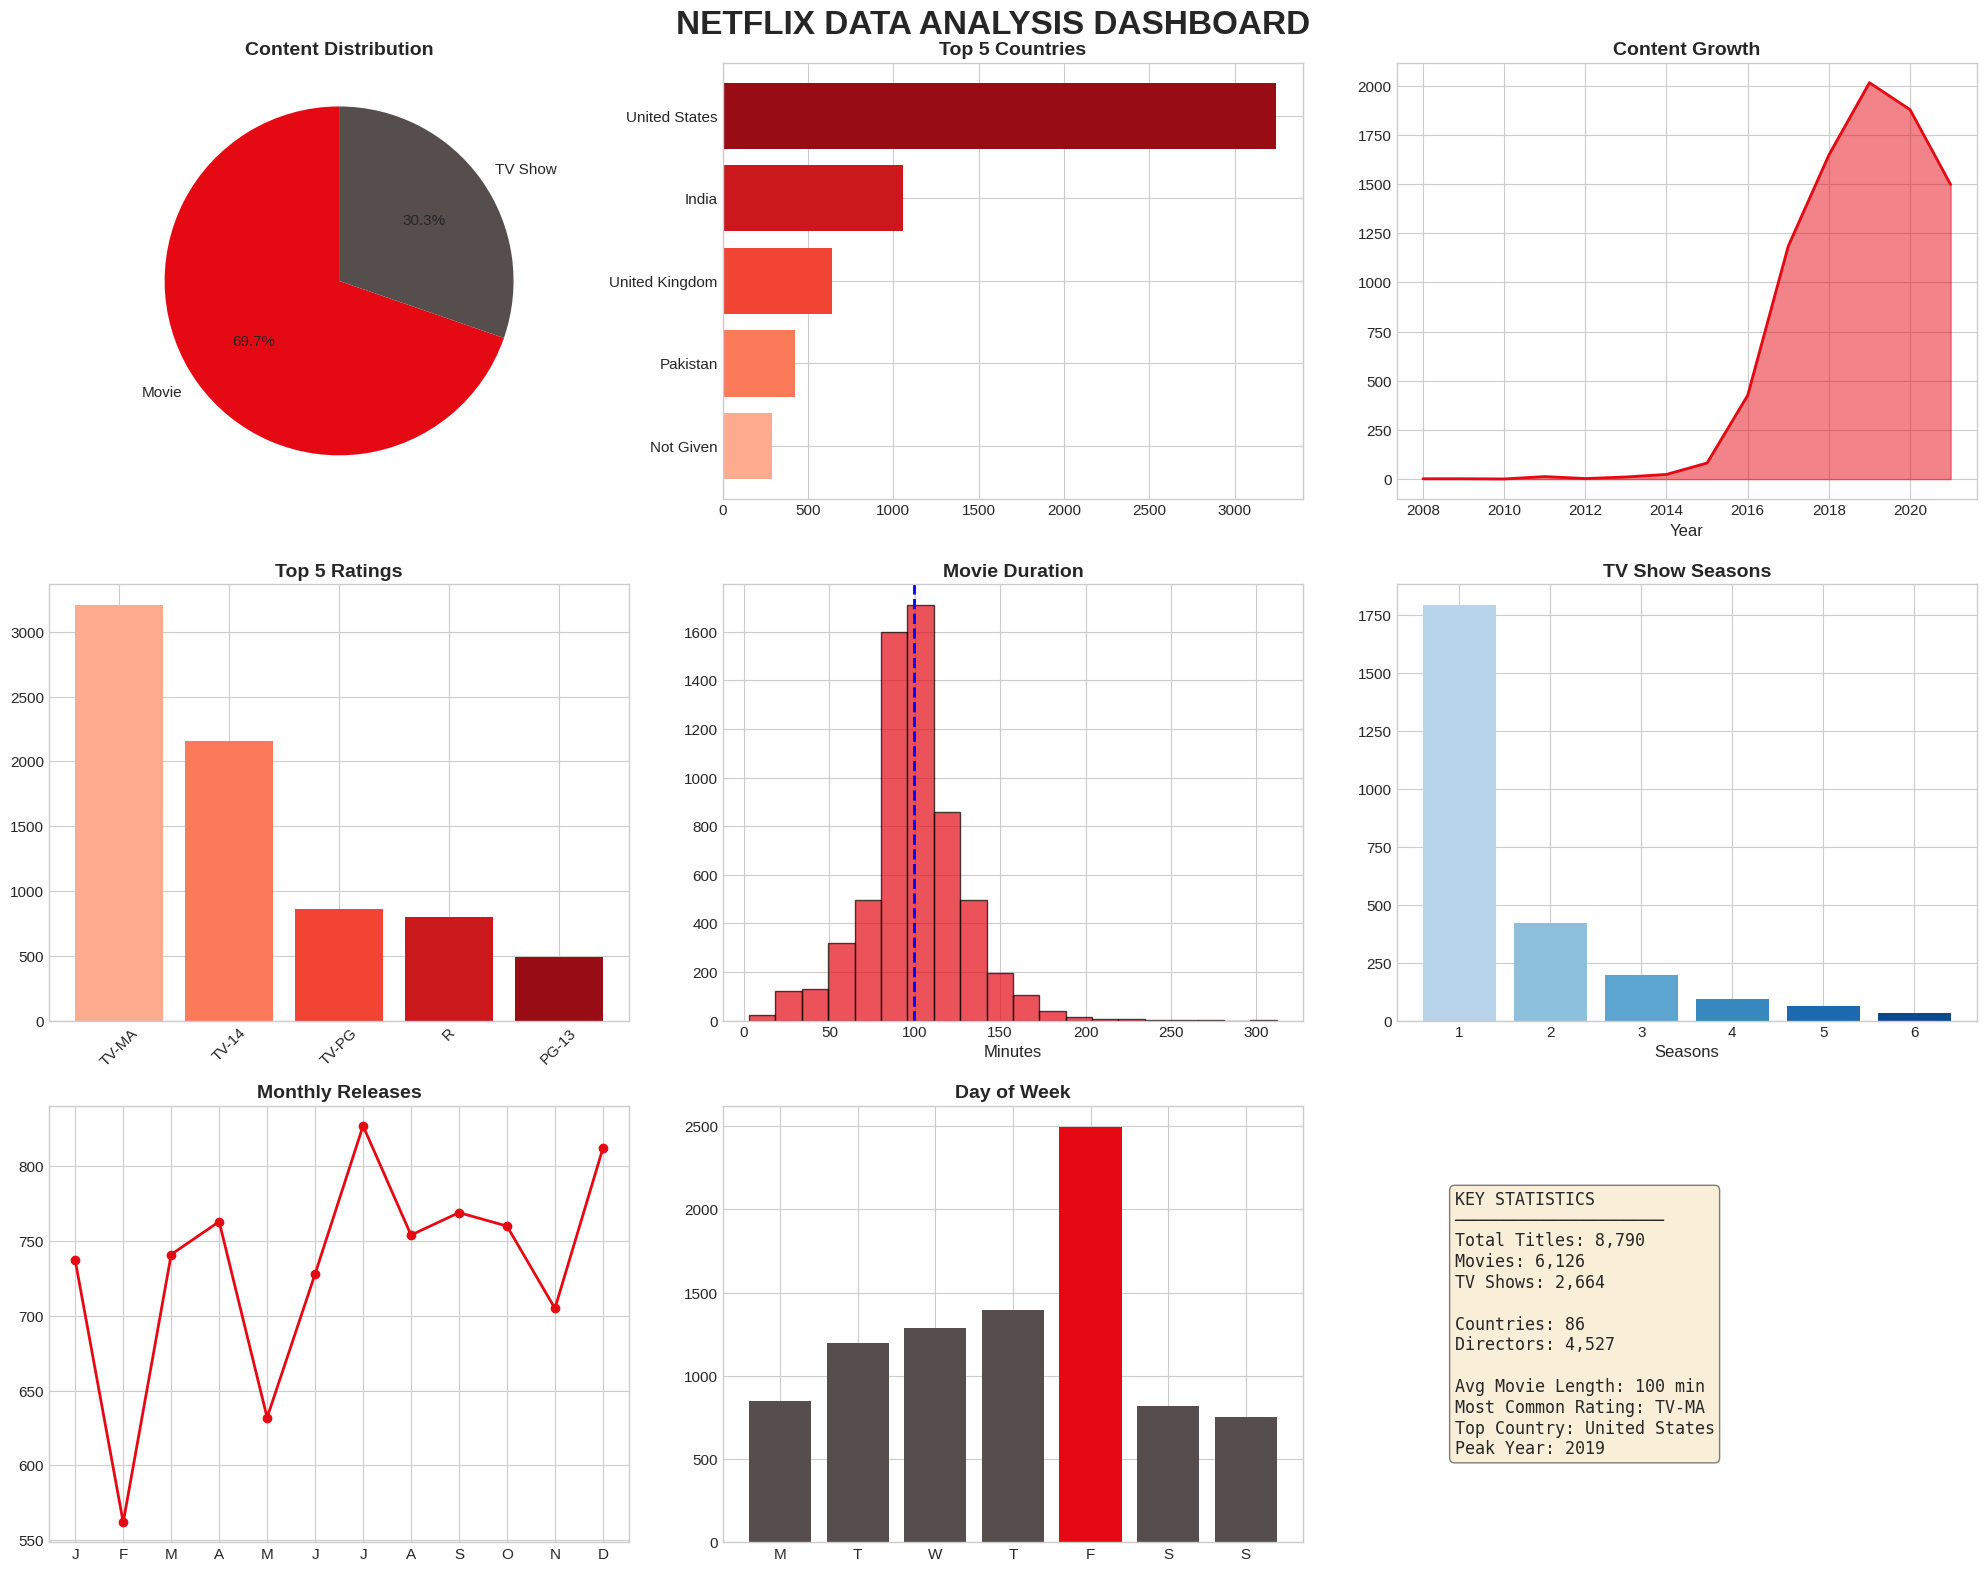

Saved: visualizations/00_dashboard.png


In [33]:
# create a dashboard with key metrics
fig = plt.figure(figsize=(20, 16))

# title
fig.suptitle('NETFLIX DATA ANALYSIS DASHBOARD', fontsize=24, fontweight='bold', y=0.98)

# 1. content type pie
ax1 = fig.add_subplot(3, 3, 1)
ax1.pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%',
        colors=[NETFLIX_RED, NETFLIX_GRAY], startangle=90)
ax1.set_title('Content Distribution', fontweight='bold')

# 2. top 5 countries
ax2 = fig.add_subplot(3, 3, 2)
top5_countries = country_counts.head(5)
ax2.barh(top5_countries.index, top5_countries.values, color=plt.cm.Reds(np.linspace(0.3, 0.9, 5))[::-1])
ax2.set_title('Top 5 Countries', fontweight='bold')
ax2.invert_yaxis()

# 3. yearly growth
ax3 = fig.add_subplot(3, 3, 3)
yearly_total = df['year_added'].value_counts().sort_index()
ax3.fill_between(yearly_total.index, yearly_total.values, alpha=0.5, color=NETFLIX_RED)
ax3.plot(yearly_total.index, yearly_total.values, color=NETFLIX_RED, linewidth=2)
ax3.set_title('Content Growth', fontweight='bold')
ax3.set_xlabel('Year')

# 4. top 5 ratings
ax4 = fig.add_subplot(3, 3, 4)
top5_ratings = rating_counts.head(5)
ax4.bar(top5_ratings.index, top5_ratings.values, color=plt.cm.Reds(np.linspace(0.3, 0.9, 5)))
ax4.set_title('Top 5 Ratings', fontweight='bold')
ax4.tick_params(axis='x', rotation=45)

# 5. movie duration distribution
ax5 = fig.add_subplot(3, 3, 5)
ax5.hist(movie_duration, bins=20, color=NETFLIX_RED, edgecolor='black', alpha=0.7)
ax5.axvline(movie_duration.mean(), color='blue', linestyle='--', linewidth=2)
ax5.set_title('Movie Duration', fontweight='bold')
ax5.set_xlabel('Minutes')

# 6. tv show seasons
ax6 = fig.add_subplot(3, 3, 6)
season_dist = show_seasons.value_counts().sort_index().head(6)
ax6.bar(season_dist.index.astype(int), season_dist.values, color=plt.cm.Blues(np.linspace(0.3, 0.9, 6)))
ax6.set_title('TV Show Seasons', fontweight='bold')
ax6.set_xlabel('Seasons')

# 7. monthly pattern
ax7 = fig.add_subplot(3, 3, 7)
monthly_total = df['month_added'].value_counts().sort_index()
ax7.plot(monthly_total.index, monthly_total.values, marker='o', color=NETFLIX_RED, linewidth=2)
ax7.set_title('Monthly Releases', fontweight='bold')
ax7.set_xticks(range(1, 13))
ax7.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])

# 8. day of week
ax8 = fig.add_subplot(3, 3, 8)
colors_dow = [NETFLIX_RED if day == 'Friday' else NETFLIX_GRAY for day in day_order]
ax8.bar(range(7), day_counts.values, color=colors_dow)
ax8.set_title('Day of Week', fontweight='bold')
ax8.set_xticks(range(7))
ax8.set_xticklabels(['M','T','W','T','F','S','S'])

# 9. key stats text box
ax9 = fig.add_subplot(3, 3, 9)
ax9.axis('off')
stats_text = f"""KEY STATISTICS
─────────────────────
Total Titles: {len(df):,}
Movies: {len(df[df['type']=='Movie']):,}
TV Shows: {len(df[df['type']=='TV Show']):,}

Countries: {df['country'].nunique()}
Directors: {df[df['director']!='Not Given']['director'].nunique():,}

Avg Movie Length: {movie_duration.mean():.0f} min
Most Common Rating: {rating_counts.index[0]}
Top Country: {country_counts.index[0]}
Peak Year: {yearly_total.idxmax()}"""

ax9.text(0.1, 0.5, stats_text, transform=ax9.transAxes, fontsize=12,
         verticalalignment='center', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('visualizations/00_dashboard.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print('Saved: visualizations/00_dashboard.png')

---

## Key Findings Summary

After analyzing Netflix's catalog, here are the main takeaways:

1. **Content Mix**: Movies make up ~70% of the library, TV shows ~30%

2. **Geographic Focus**: US dominates with 37% of content, followed by India (12%)

3. **Target Audience**: TV-MA (mature audiences) is the most common rating - Netflix clearly targets adults

4. **Growth Pattern**: Explosive growth from 2015-2019, slight dip after that

5. **Release Strategy**: Friday is the preferred release day - weekend binge strategy!

6. **Content Length**: Average movie is ~100 min, most TV shows have just 1 season

7. **Popular Genres**: Drama and International content dominate both movies and TV shows